In [1]:
import os

import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = True

In [2]:
def plot_fit_history(history):
  tr_acc = history['acc']
  val_acc = history['val_acc']
  tr_loss = history['loss']
  val_loss = history['val_loss']
  epochs_range = range(1, len(tr_acc) + 1)
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss', color=color)
  l1, = ax1.plot(epochs_range, tr_loss, 's:', color=color, label='Training Loss', markeredgewidth=1, fillstyle='none')
  l2, = ax1.plot(epochs_range, val_loss, 'o-', color=color, label='Validation Loss')
  ax1.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  l3, = ax2.plot(epochs_range, tr_acc, 's:', color=color, label='Training Acc', markeredgewidth=1, fillstyle='none')
  l4, = ax2.plot(epochs_range, val_acc, 'o-', color=color, label='Validation Acc')
  ax2.tick_params(axis='y', labelcolor=color, grid_color=color, grid_linestyle=':')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
  plt.legend((l1, l2, l3, l4), ('Training Loss', 'Validation Loss', 'Training Acc', 'Validation Acc'), loc=(1.2,0.5))
  plt.show()

In [3]:
if not os.path.isfile('music.txt'): 
  !wget https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/music.txt
!ls

--2020-11-23 21:41:24--  https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/music.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4659855 (4.4M) [text/plain]
Saving to: ‘music.txt’

music.txt           100%[===================>]   4.44M  --.-KB/s    in 0.1s    

2020-11-23 21:41:25 (34.5 MB/s) - ‘music.txt’ saved [4659855/4659855]

music.txt  sample_data


In [4]:
class DataSet:
  def __init__(self, songs):
    # list of songs
    self.s = songs
    # number of notes in each song
    self.n_s = []
    for s0 in songs:
      self.n_s.append(s0.shape[0])
    self.n_s = np.array(self.n_s)
    # total number of notes in all songs
    self.n_t = self.n_s.sum()
    # number of songs
    self.n_n = len(self.s)
    # all nodes as one sequence
    self.orig_data = np.concatenate(self.s)

# list of all songs from the datafile
s = []

with open('music.txt') as fp:
  for cnt, line in enumerate(fp):
    s0 = np.fromstring(line, sep=" ", dtype=int)
    s.append(s0)

full_set = DataSet(s)

print(full_set.n_t)

print(full_set.orig_data.shape)

1553149
(1553149,)


In [5]:
# class index to class label mapping
data_dict = np.unique(full_set.orig_data);

dim = len(data_dict)

# class label to class index mapping
label_to_int = dict((l, i) for i, l in enumerate(data_dict))

# one-hot encoding from class indices
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[targets]
    return res.reshape(list(targets.shape)+[nb_classes])

# encoding full DataSet
# by adding new attributes to the data structure
full_set.int_s = []
full_set.one_hot_s = []
for s0 in full_set.s:
  int_tmp = np.array([label_to_int[l] for l in s0], dtype=int)
  # data as class indices
  full_set.int_s.append(int_tmp)
  # data as one-hot vectors
  full_set.one_hot_s.append(get_one_hot(int_tmp, dim))

print(full_set.one_hot_s[0].shape)

(1004, 89)


In [6]:
n_validation_songs = 100

val_d = DataSet(s[0:n_validation_songs])
val_d.int_s = full_set.int_s[0:n_validation_songs]
val_d.one_hot_s = full_set.one_hot_s[0:n_validation_songs]

tr_d =  DataSet(s[n_validation_songs:])
tr_d.int_s = full_set.int_s[n_validation_songs:]
tr_d.one_hot_s = full_set.one_hot_s[n_validation_songs:]

In [7]:
print(val_d.one_hot_s[0].shape)

(1004, 89)


In [8]:
batch = 64
timelapse = 32

def generator(data, b=batch, t=timelapse):
  n_t_p = data.n_t - data.n_n*(t+1)
  n_s_p = data.n_s - (t+1)
  while True:
    samples = np.zeros((b, t, dim))
    targets = np.zeros((b)) 
    for k in range (b):
      i = random.randrange(0, n_t_p)
      j = 0;
      while i >= n_s_p[j]:
         i -= n_s_p[j]
         j += 1
      samples[k] = data.one_hot_s[j][i:i+t]
      targets[k] = data.int_s[j][i+t]

    yield samples, targets

In [9]:
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden = self.init_hidden()

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the dense layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim))
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [10]:
sample_size = tr_d.n_t - timelapse*tr_d.n_n
val_size = val_d.n_t - timelapse*val_d.n_n

h_dim = 256
model = Model(dim, h_dim, batch, dim, 2)
if use_cuda and torch.cuda.is_available():
    model.cuda()

In [11]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.RMSprop(model.parameters(), lr=learning_rate)

In [12]:
hist = {"acc": [], "loss": [], "val_loss": [], "val_acc": []}


def train(num_epochs, tr_gen, val_gen):
  for t in range(num_epochs):
    correct = 0
    total = 0
    for b1 in range(0, sample_size, batch*timelapse):
      
      # Clear stored gradient
      model.zero_grad()
      optimiser.zero_grad()

      # Forward pass
      x_batch, y_batch = next(tr_gen)
      x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
      y_batch = torch.from_numpy(y_batch).long()
      if use_cuda and torch.cuda.is_available():
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
      y_pred = model(x_batch)
      _, predicted = torch.max(y_pred.data, 1)
      labels = y_batch
      correct += (predicted.cpu() == labels.cpu()).sum()
      total += labels.size(0)
      loss = loss_fn(y_pred, y_batch)
      if b1 == 0:
        # print(y_pred.shape)
        print("Epoch ", t, "Loss: ", loss.item())
      currloss = loss.item()

      # Backward pass
      loss.backward()

      # Update parameters
      optimiser.step()
    
    accuracy = 100 * correct.item() / total
    hist["loss"].append(currloss)
    hist["acc"].append(accuracy)
    print("acc: ", accuracy)

    # Validation
    correct = 0
    total = 0
    loss = 0
    n_b = 0
    with torch.no_grad():
      for b in range(0, val_size, batch*timelapse):
        x_batch, y_batch = next(val_gen)
        x_batch = torch.from_numpy(np.swapaxes(x_batch, 0, 1)).float()
        y_batch = torch.from_numpy(y_batch).long()
        if use_cuda and torch.cuda.is_available():
          x_batch = x_batch.cuda()
          y_batch = y_batch.cuda()
        y_pred = model(x_batch)
        _, predicted = torch.max(y_pred.data, 1)
        labels = y_batch
        correct += (predicted.cpu() == labels.cpu()).sum()
        total += labels.size(0)
        loss += loss_fn(y_pred, y_batch)
        n_b += 1
      accuracy = 100 * correct.item() / total
      loss = loss.item() / n_b 
    hist["val_loss"].append(loss)
    hist["val_acc"].append(accuracy)
    print("Val acc: ", accuracy, "Val loss: ", loss)

In [13]:
gen = generator(tr_d)
vgen = generator(val_d)

In [14]:
train(60, gen, vgen)

Epoch  0 Loss:  4.491116046905518
acc:  5.104166666666667
Val acc:  7.421875 Val loss:  3.473607149991122
Epoch  1 Loss:  3.571568727493286
acc:  8.089539007092199
Val acc:  8.735795454545455 Val loss:  3.344890594482422
Epoch  2 Loss:  3.325571298599243
acc:  9.652039007092199
Val acc:  9.161931818181818 Val loss:  3.2685775756835938
Epoch  3 Loss:  3.3116962909698486
acc:  10.824468085106384
Val acc:  9.588068181818182 Val loss:  3.220408006147905
Epoch  4 Loss:  3.3320016860961914
acc:  11.93040780141844
Val acc:  10.262784090909092 Val loss:  3.166618000377308
Epoch  5 Loss:  3.1565351486206055
acc:  12.57313829787234
Val acc:  12.073863636363637 Val loss:  3.149910666725852
Epoch  6 Loss:  3.2843778133392334
acc:  13.687943262411348
Val acc:  12.002840909090908 Val loss:  3.0892989418723364
Epoch  7 Loss:  3.0941922664642334
acc:  14.018173758865249
Val acc:  14.133522727272727 Val loss:  3.0331074107776987
Epoch  8 Loss:  3.115382671356201
acc:  15.498670212765957
Val acc:  15.23

In [15]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/3
train(25, gen, vgen)

Epoch  0 Loss:  2.2516565322875977
acc:  35.90425531914894
Val acc:  25.603693181818183 Val loss:  2.6712590997869317
Epoch  1 Loss:  2.000704765319824
acc:  36.25443262411348
Val acc:  24.609375 Val loss:  2.6889020746404473
Epoch  2 Loss:  2.4500036239624023
acc:  36.569148936170215
Val acc:  26.27840909090909 Val loss:  2.6617681329900567
Epoch  3 Loss:  2.5639870166778564
acc:  37.398049645390074
Val acc:  23.117897727272727 Val loss:  2.7203924005681817
Epoch  4 Loss:  2.399341344833374
acc:  37.42464539007092
Val acc:  24.147727272727273 Val loss:  2.6522695367986504
Epoch  5 Loss:  2.291836977005005
acc:  37.14982269503546
Val acc:  24.71590909090909 Val loss:  2.676571412519975
Epoch  6 Loss:  2.4911916255950928
acc:  37.38696808510638
Val acc:  25.248579545454547 Val loss:  2.667924014004794
Epoch  7 Loss:  1.9008244276046753
acc:  37.898936170212764
Val acc:  25.248579545454547 Val loss:  2.681618083607067
Epoch  8 Loss:  2.434048891067505
acc:  38.01418439716312
Val acc:  25

In [16]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/9
train(25, gen, vgen)

Epoch  0 Loss:  2.1625754833221436
acc:  40.101950354609926
Val acc:  25.852272727272727 Val loss:  2.684379230846058
Epoch  1 Loss:  2.1382217407226562
acc:  40.31693262411348
Val acc:  25.852272727272727 Val loss:  2.685132633556019
Epoch  2 Loss:  2.024211883544922
acc:  40.3125
Val acc:  26.242897727272727 Val loss:  2.6523021351207388
Epoch  3 Loss:  2.4751038551330566
acc:  40.562943262411345
Val acc:  26.207386363636363 Val loss:  2.6441187425093218
Epoch  4 Loss:  2.50638484954834
acc:  40.77349290780142
Val acc:  27.201704545454547 Val loss:  2.6244253678755327
Epoch  5 Loss:  2.102613925933838
acc:  40.73581560283688
Val acc:  25.568181818181817 Val loss:  2.6707923195578833
Epoch  6 Loss:  2.2722065448760986
acc:  40.777925531914896
Val acc:  27.34375 Val loss:  2.6720738844438032
Epoch  7 Loss:  2.1871378421783447
acc:  40.669326241134755
Val acc:  24.396306818181817 Val loss:  2.709649519486861
Epoch  8 Loss:  2.213632345199585
acc:  40.613918439716315
Val acc:  25.1420454

In [17]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/27
train(25, gen, vgen)

Epoch  0 Loss:  1.9475514888763428
acc:  41.996897163120565
Val acc:  25.958806818181817 Val loss:  2.6377045024525034
Epoch  1 Loss:  2.1999900341033936
acc:  42.216312056737586
Val acc:  26.526988636363637 Val loss:  2.5910365364768286
Epoch  2 Loss:  1.919020414352417
acc:  41.575797872340424
Val acc:  24.89346590909091 Val loss:  2.7077192826704546
Epoch  3 Loss:  1.9114351272583008
acc:  41.67553191489362
Val acc:  26.384943181818183 Val loss:  2.6757198680530894
Epoch  4 Loss:  2.4305648803710938
acc:  41.3741134751773
Val acc:  25.49715909090909 Val loss:  2.6803490031849253
Epoch  5 Loss:  1.845369815826416
acc:  41.93040780141844
Val acc:  25.88778409090909 Val loss:  2.6786882227117363
Epoch  6 Loss:  1.8202470541000366
acc:  41.850620567375884
Val acc:  25.78125 Val loss:  2.6491092335094106
Epoch  7 Loss:  1.99307119846344
acc:  42.05452127659574
Val acc:  26.633522727272727 Val loss:  2.6260372508655894
Epoch  8 Loss:  2.364382743835449
acc:  41.850620567375884
Val acc:  2

In [ ]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/80
train(25, gen, vgen)

Epoch  0 Loss:  1.9460572004318237
acc:  42.24512411347518
Val acc:  25.426136363636363 Val loss:  2.686746423894709
Epoch  1 Loss:  1.870997428894043
acc:  42.506648936170215
Val acc:  25.78125 Val loss:  2.6741178685968574
Epoch  2 Loss:  2.106154680252075
acc:  42.76152482269504
Val acc:  27.84090909090909 Val loss:  2.5963387922807173
Epoch  3 Loss:  1.9871060848236084


In [19]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/240

train(25, gen, vgen)

Epoch  0 Loss:  1.9967155456542969
acc:  42.823581560283685
Val acc:  25.816761363636363 Val loss:  2.6812537800181997
Epoch  1 Loss:  2.023739814758301
acc:  42.229609929078016
Val acc:  24.786931818181817 Val loss:  2.7573027177290483
Epoch  2 Loss:  2.0311708450317383
acc:  42.234042553191486
Val acc:  26.953125 Val loss:  2.656595056707209
Epoch  3 Loss:  2.211827039718628
acc:  42.475620567375884
Val acc:  26.207386363636363 Val loss:  2.6873491460626777
Epoch  4 Loss:  2.21423602104187
acc:  42.51551418439716
Val acc:  27.414772727272727 Val loss:  2.6399881189519707
Epoch  5 Loss:  2.029850482940674
acc:  42.81693262411348
Val acc:  28.23153409090909 Val loss:  2.653974706476385
Epoch  6 Loss:  2.0164244174957275
acc:  42.52216312056738
Val acc:  26.420454545454547 Val loss:  2.68274602023038
Epoch  7 Loss:  2.178403615951538
acc:  42.83244680851064
Val acc:  26.775568181818183 Val loss:  2.620539058338512
Epoch  8 Loss:  2.2798562049865723
acc:  42.5886524822695
Val acc:  26.70

In [20]:
for param_group in optimiser.param_groups:
        param_group['lr'] = learning_rate/720

train(25, gen, vgen)

Epoch  0 Loss:  2.2304999828338623
acc:  42.471187943262414
Val acc:  26.704545454545453 Val loss:  2.6211185455322266
Epoch  1 Loss:  1.9987725019454956
acc:  42.66400709219858
Val acc:  25.49715909090909 Val loss:  2.6883728720925073
Epoch  2 Loss:  2.2178640365600586
acc:  42.471187943262414
Val acc:  25.355113636363637 Val loss:  2.694019317626953
Epoch  3 Loss:  2.101149559020996
acc:  42.6063829787234
Val acc:  26.171875 Val loss:  2.66247541254217
Epoch  4 Loss:  2.022670269012451
acc:  43.060726950354606
Val acc:  25.88778409090909 Val loss:  2.7000444585626777
Epoch  5 Loss:  1.9879670143127441
acc:  42.77482269503546
Val acc:  25.49715909090909 Val loss:  2.7085819244384766
Epoch  6 Loss:  2.208544969558716
acc:  42.5354609929078
Val acc:  25.532670454545453 Val loss:  2.708743008700284
Epoch  7 Loss:  2.076159715652466
acc:  42.398049645390074
Val acc:  26.100852272727273 Val loss:  2.694682901555842
Epoch  8 Loss:  2.095120429992676
acc:  42.75265957446808
Val acc:  24.1832

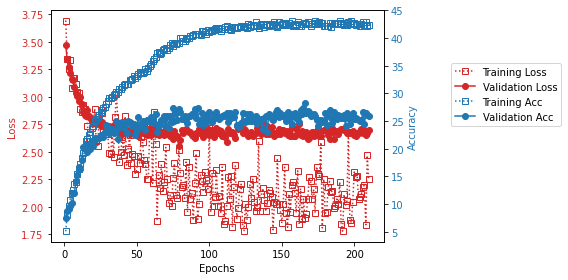

In [21]:
plot_fit_history(hist)
